In [1]:
# Install Kaggle API
!pip install kaggle

# Make a Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Give permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset -p ./dataset

# Unzip it
!unzip ./dataset/potato-leaf-disease-dataset.zip -d ./dataset


Dataset URL: https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset
License(s): unknown
  0% 0.00/25.2M [00:00<?, ?B/s]
100% 25.2M/25.2M [00:00<00:00, 946MB/s]
Archive:  ./dataset/potato-leaf-disease-dataset.zip
  inflating: ./dataset/Potato/Test/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/08194ca3-f0b2-4aaa-8df8-5ec5ddc6696a___RS_Early.B 8151.JPG  
  inflating: ./dataset/Potato/Test/Potato___Early_blight/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

In [ ]:
train_dir = '/content/dataset/Potato/Train'
validation_dir = '/content/dataset/Potato/Valid'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 900 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dir = os.path.join('/content/dataset/Potato/Test')
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


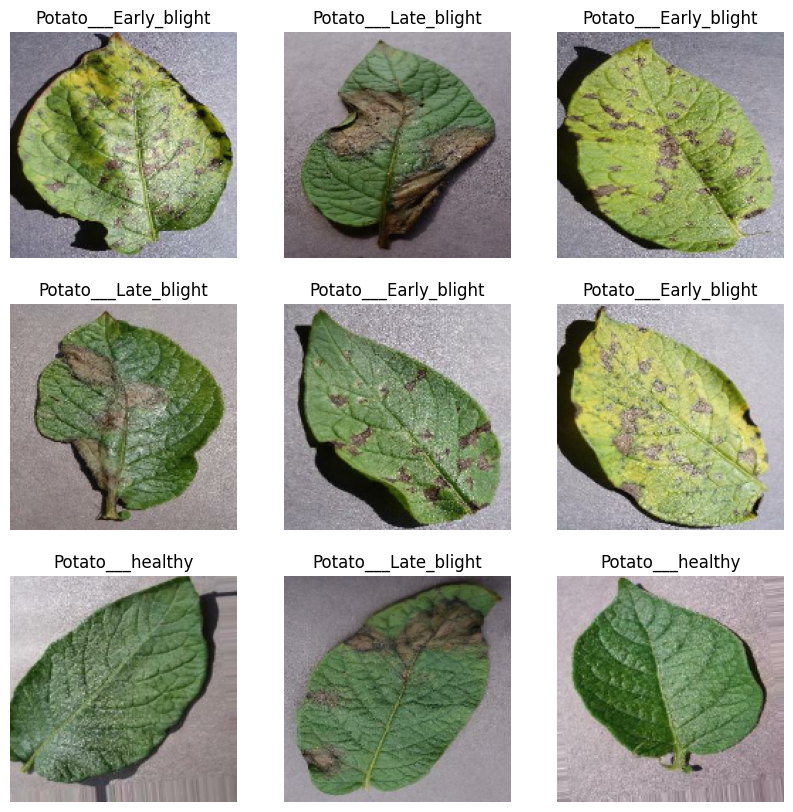

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

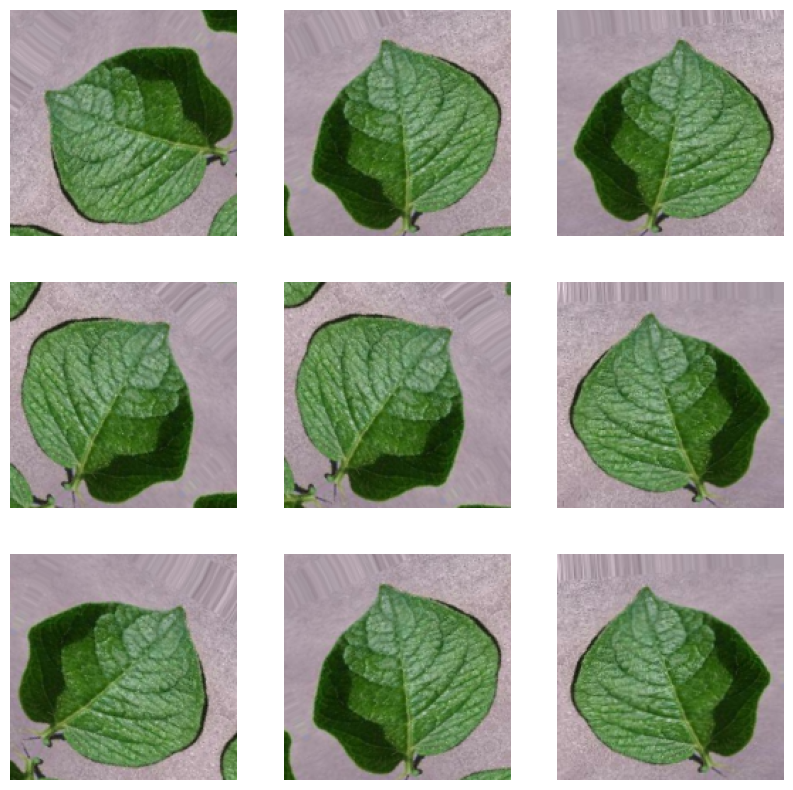

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 5, 5, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         5,379 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,679,202 (67.44 MB)

 Trainable params: 5,379 (21.01 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
len(model.trainable_variables)

2

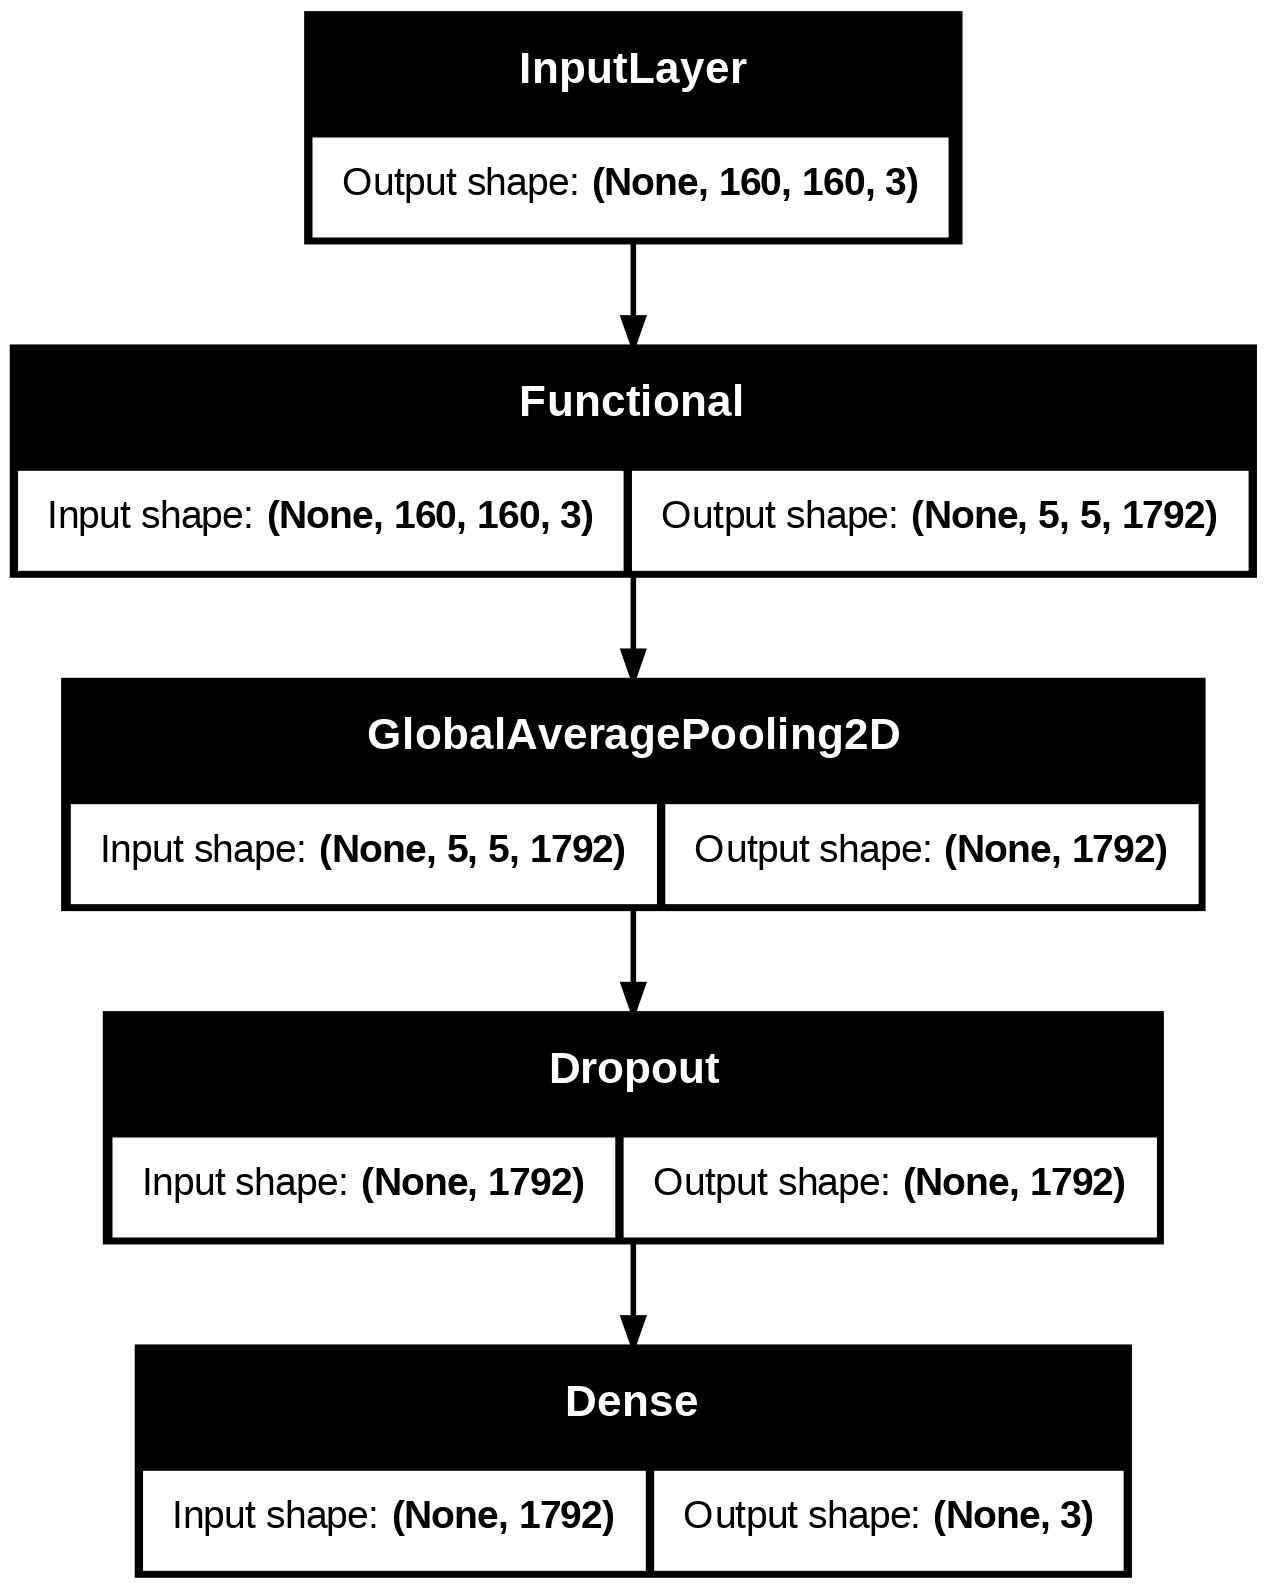

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3264 - loss: 1.1211


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.12
initial accuracy: 0.34


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 66s 823ms/step - accuracy: 0.6589 - loss: 0.8261 - val_accuracy: 0.8729 - val_loss: 0.4355
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.8947 - loss: 0.3907 - val_accuracy: 0.9492 - val_loss: 0.2953
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9361 - loss: 0.2712 - val_accuracy: 0.9661 - val_loss: 0.2225
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9415 - loss: 0.2210 - val_accuracy: 0.9534 - val_loss: 0.2102
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9593 - loss: 0.1822 - val_accuracy: 0.9576 - val_loss: 0.1810
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9615 - loss: 0.1590 - val_accuracy: 0.9788 - val_loss: 0.1536
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9576 - loss: 0.1616 - val_accuracy: 0.9661 - val_loss: 0.1520
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9721 - loss: 0.1472 - val_accuracy: 0.9619 

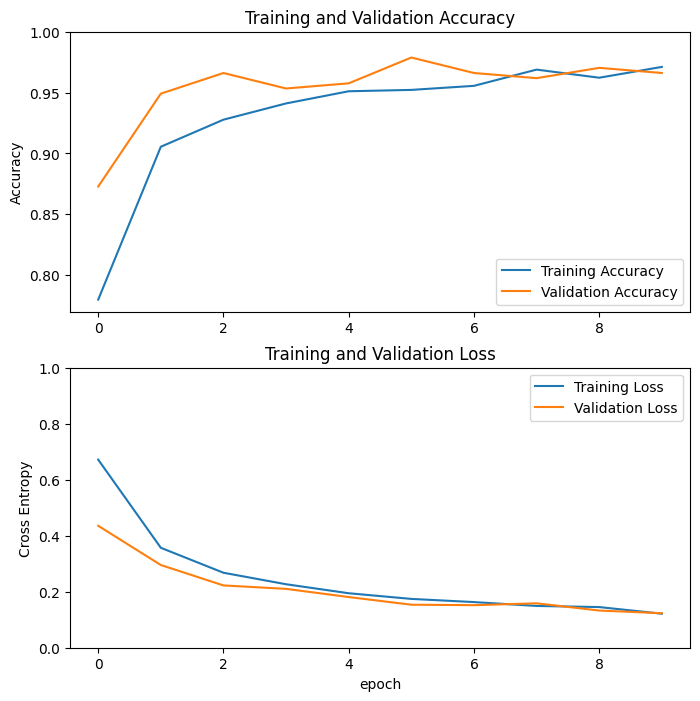

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 5, 5, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         5,379 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,679,202 (67.44 MB)

 Trainable params: 17,467,235 (66.63 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [ ]:
len(model.trainable_variables)

333

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.7917 - loss: 0.5712 - val_accuracy: 0.9703 - val_loss: 0.1064
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.8605 - loss: 0.3755 - val_accuracy: 0.9661 - val_loss: 0.0926
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8998 - loss: 0.2512 - val_accuracy: 0.9576 - val_loss: 0.1062
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9287 - loss: 0.2043 - val_accuracy: 0.9576 - val_loss: 0.1036
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9556 - loss: 0.1617 - val_accuracy: 0.9576 - val_loss: 0.1202
Epoch 16/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9738 - loss: 0.1255 - val_accuracy: 0.9703 - val_loss: 0.1228
Epoch 17/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9811 - loss: 0.0875 - val_accuracy: 0.9746 - val_loss: 0.1195
Epoch 18/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9856 - loss: 0.0726 - val_accu

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

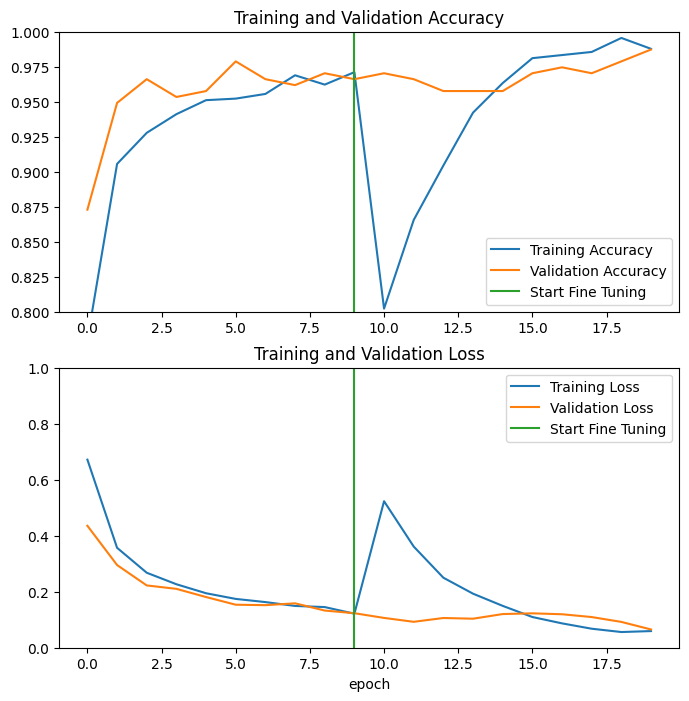

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9583 - loss: 0.1496
Test accuracy : 0.96875


Predictions:
 [0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0]
Labels:
 [2 2 2 2 0 1 2 1 2 1 0 2 1 0 0 1 2 1 2 0 1 2 2 0 0 2 1 2 2 1 1 1]


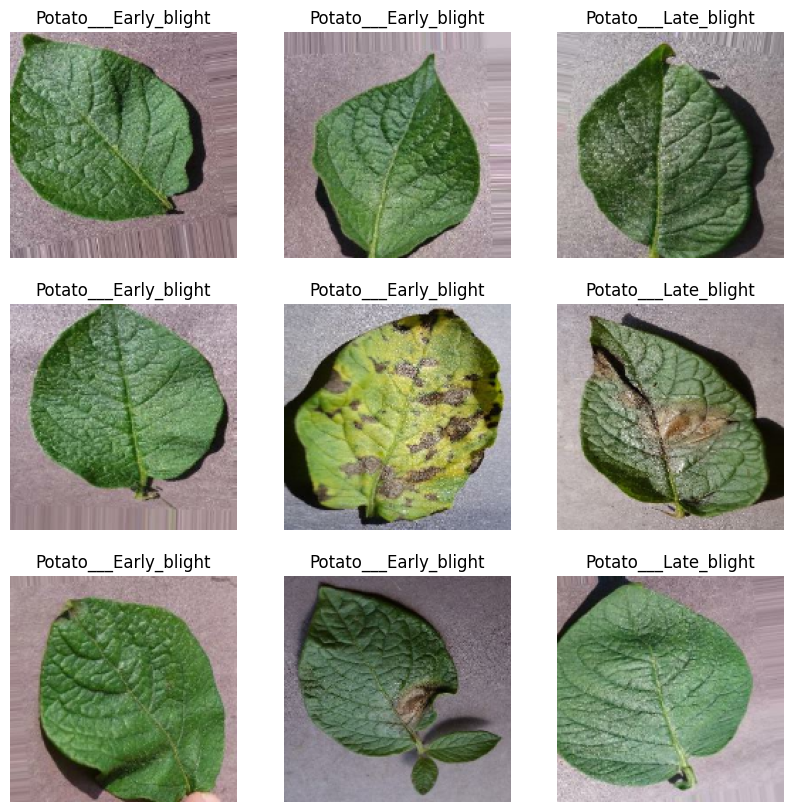

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save("plant_Model.keras")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
